In [70]:
import matplotlib.pyplot as plt
import scipy.io
import numpy as np
#import random
import math
import spectral
from sklearn.decomposition import PCA
from sklearn.decomposition import RandomizedPCA
from sklearn.utils import shuffle

import tensorflow as tf
from tensorflow.contrib.layers import flatten

#import warnings; warnings.simplefilter('ignore')

#Global parameters
rpca_n_components = 30
patch_size = 5

test_fraction = 0.2
n_samples = 350
learning_rate = 0.01

epochs = 3001
batch_size = 200

In [2]:
print(tf.__version__)

1.1.0


In [3]:
input_mat= scipy.io.loadmat('Indian_pines.mat')['indian_pines']
groundtruth_mat = scipy.io.loadmat('Indian_pines_gt.mat')['indian_pines_gt']

In [4]:
print("Input shape:", input_mat.shape, "Input data type:", input_mat.dtype)

Input shape: (145, 145, 220) Input data type: uint16


In [5]:
n_classes = len(np.unique(groundtruth_mat)) - 1
print("Number of classes: ", n_classes)

Number of classes:  16


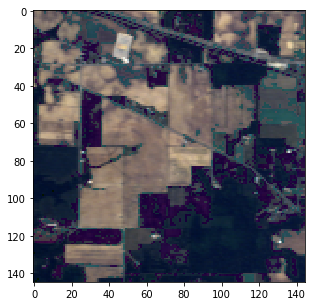

In [6]:
image = spectral.imshow(input_mat, bands=(29, 19, 9), figsize = (5,5))

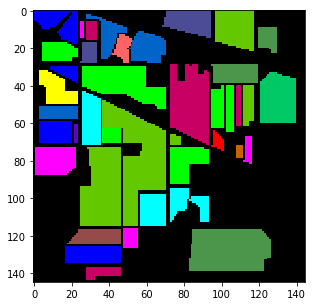

In [7]:
ground_truth = spectral.imshow(classes = groundtruth_mat, figsize = (5,5))

In [8]:
hight = input_mat.shape[0]
width = input_mat.shape[1]
band = input_mat.shape[2]

print("hight:", hight, " width:", width, " band:", band)

hight: 145  width: 145  band: 220


In [9]:
groundtruth_mat

array([[3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       [3, 3, 3, ..., 0, 0, 0],
       ..., 
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [10]:
groundtruth_mat.shape

(145, 145)

In [11]:
#reduce dimensions based on rpca_n_compoonents
print(input_mat.shape)

input_mat_1D = np.reshape(input_mat, (-1, input_mat.shape[2]))

print(input_mat_1D.shape)

rpca = RandomizedPCA(n_components=rpca_n_components, whiten=False)
input_mat_1D_reduced = rpca.fit_transform(input_mat_1D)
input_mat_reduced = np.reshape(input_mat_1D_reduced, (input_mat.shape[0], input_mat.shape[1], -1))

print("Current shape: ", input_mat_reduced.shape)
print("Explained variance ratio is: ", rpca.explained_variance_ratio_.sum())

(145, 145, 220)
(21025, 220)
Current shape:  (145, 145, 30)
Explained variance ratio is:  0.986865


/Users/Zhusparker/miniconda3/envs/EE259/lib/python3.5/site-packages/sklearn/utils/deprecation.py:58: DeprecationWarning: Class RandomizedPCA is deprecated; RandomizedPCA was deprecated in 0.18 and will be removed in 0.20. Use PCA(svd_solver='randomized') instead. The new implementation DOES NOT store whiten ``components_``. Apply transform to get them.
  warnings.warn(msg, category=DeprecationWarning)


In [12]:
input_mat_reduced[0][0]

array([ 5014.88720703,  1456.85461426,    72.770401  ,    71.10762024,
        -435.62539673,    69.26174927,   136.93505859,  -302.79440308,
         259.28933716,   -62.27318954,  -119.91477966,   -38.90835571,
        -126.28152466,   216.76986694,  -112.56215668,   118.95696259,
         121.01441956,   380.43664551,   244.59251404,   -44.35416031,
          22.57713699,    97.37257385,    78.21074677,  -153.17672729,
         -54.35735703,   -85.04332733,    58.31298447,    17.22397804,
          64.69927979,    29.92755508], dtype=float32)

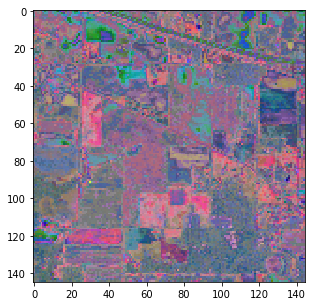

In [13]:
image = spectral.imshow(input_mat_reduced, bands=(5, 10, 20), figsize = (5,5))

In [14]:
input_mat_reduced.dtype

dtype('float32')

In [15]:
#dimensions reduced 
#scale the value to [0, 1]

#input_mat_reduced = input_mat_reduced.astype(np.float32)
#print(input_mat_reduced.dtype)
for i in range(rpca_n_components):
    
    input_mat_reduced[:, :, i] = (input_mat_reduced[:, :, i] - np.min(input_mat_reduced[:, :, i])) / (np.max(input_mat_reduced[:, :, i]) - np.min(input_mat_reduced[:, :, i]))
    
print(input_mat_reduced.dtype)
print(input_mat_reduced[0][0])

float32
[ 0.66223258  0.53276372  0.24728921  0.36564693  0.23759358  0.52624243
  0.50847292  0.35563868  0.4503434   0.39409152  0.41716903  0.45351464
  0.44360557  0.48609084  0.37228015  0.49970901  0.49480852  0.49261966
  0.7224344   0.46947998  0.54914165  0.59242082  0.56218028  0.41693822
  0.54099363  0.38200912  0.47233108  0.50258034  0.56562066  0.50733411]


In [16]:
#scale the value from 0 to 1

#input_mat = input_mat.astype(float)
#input_mat -= np.min(input_mat)
#input_mat /= np.max(input_mat)

#print(input_mat.dtype)

In [17]:
#normalized the value

#mean_array = np.ndarray(shape=(band,),dtype=float32)
#for i in range(band):
#    mean_array[i] = np.mean(input_mat[:,:,i])
#    input_mat[:,:,i] -= mean_array[i]

In [18]:
#without transposing for now

#test = np.transpose(input_mat,(2,0,1))

#print(test.dtype)
#print(test.shape)

In [19]:
#decompose based on the patch_size

lower = int(math.floor(patch_size / 2))
upper = int(math.ceil(patch_size / 2))

print("lower:", lower)
print("upper:", upper)

def decompose(x,y):
    height_slice = slice(x - lower, x + upper)
    width_slice = slice(y - lower, y + upper)
    patch = input_mat_reduced[height_slice, width_slice, :]
    
    return np.array(patch)

lower: 2
upper: 3


In [20]:
test = decompose(2, 2)
print(test[0][0])
print(groundtruth_mat[2, 2])

[ 0.66223258  0.53276372  0.24728921  0.36564693  0.23759358  0.52624243
  0.50847292  0.35563868  0.4503434   0.39409152  0.41716903  0.45351464
  0.44360557  0.48609084  0.37228015  0.49970901  0.49480852  0.49261966
  0.7224344   0.46947998  0.54914165  0.59242082  0.56218028  0.41693822
  0.54099363  0.38200912  0.47233108  0.50258034  0.56562066  0.50733411]
3


In [21]:
classes = []
final = []
location = []
for i in range(n_classes):
    classes.append([])

In [22]:
for i in range(lower, hight - upper + 1):
    #print(i)
    for j in range(lower, width - upper + 1):
        curr_inp = decompose(i,j)
            
        curr_tar = groundtruth_mat[i, j]
        if(curr_tar != 0): 
            classes[curr_tar-1].append(curr_inp)
            final.append(curr_inp)
            location.append([i, j])

In [23]:
print(len(final))
print(final[0].shape)
print(len(location))

10086
(5, 5, 30)
10086


In [24]:
#ith class, jth patch, y-axle, x-axle
print(classes[2][0][0][0])

[ 0.66223258  0.53276372  0.24728921  0.36564693  0.23759358  0.52624243
  0.50847292  0.35563868  0.4503434   0.39409152  0.41716903  0.45351464
  0.44360557  0.48609084  0.37228015  0.49970901  0.49480852  0.49261966
  0.7224344   0.46947998  0.54914165  0.59242082  0.56218028  0.41693822
  0.54099363  0.38200912  0.47233108  0.50258034  0.56562066  0.50733411]


In [25]:
for i in classes:
    print(len(i))

46
1428
777
237
468
730
28
478
20
967
2413
593
205
1265
338
93


In [26]:
train_patch, train_label, test_patch, test_label = [], [], [], []

test_count = 0
for i in range(n_classes):
    #print(i)
    test_size = int(len(classes[i])*test_fraction)
    test_count +=test_size
    
    patches = classes[i]
    patches = shuffle(patches)
    
    train_patch.append(patches[:-test_size])
        
    test_patch.extend(patches[-test_size:])
    test_label.extend(np.full(test_size, i, dtype=np.int8))

print("num of test:", test_count)
    
for i in range(n_classes):
    if(len(train_patch[i]) < n_samples):
        tmp = train_patch[i]
        for j in range(int(n_samples/len(train_patch[i]))):
            #print("test", j)
            train_patch[i] = shuffle(train_patch[i])
            train_patch[i] += tmp
    train_patch[i] = shuffle(train_patch[i])
    train_patch[i] = train_patch[i][:n_samples]
    print(i)

num of test: 2011
0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15


In [27]:
for i in train_patch:
    print(len(i))

350
350
350
350
350
350
350
350
350
350
350
350
350
350
350
350


In [28]:
print(len(test_patch))

2011


In [29]:
print(train_patch[0][0].shape)
train_patch = np.asarray(train_patch)
print(train_patch.shape)
train_patch = train_patch.reshape((-1,patch_size, patch_size, rpca_n_components))
print(train_patch.shape)
print(train_patch[2][0][0])

(5, 5, 30)
(16, 350, 5, 5, 30)
(5600, 5, 5, 30)
[ 0.55523896  0.50149143  0.15240361  0.27535123  0.36481789  0.40068176
  0.43229169  0.6559552   0.65207928  0.25501558  0.56288129  0.33348104
  0.40060839  0.32866624  0.39783603  0.61890393  0.60568827  0.35201389
  0.68853652  0.52960938  0.65303713  0.5355199   0.54480296  0.50644088
  0.7461412   0.39140534  0.4902744   0.53754658  0.55206305  0.50507617]


In [30]:
train_label = np.array(train_label)
for i in range(n_classes):
    train_label = np.append(train_label, np.full(n_samples, i, dtype=np.int8))

In [31]:
train_label.dtype

dtype('float64')

In [32]:
train_label = train_label.astype(np.uint8)

In [33]:
train_label.shape

(5600,)

In [34]:
train_label

array([ 0,  0,  0, ..., 15, 15, 15], dtype=uint8)

In [35]:
train_patch.dtype

dtype('float32')

In [36]:
train_patch

array([[[[ 0.58535272,  0.48653337,  0.16086614, ...,  0.46314538,
           0.46153107,  0.48070413],
         [ 0.44360372,  0.45551169,  0.10037783, ...,  0.53938973,
           0.52746516,  0.57501954],
         [ 0.43576264,  0.45659843,  0.09547783, ...,  0.63983119,
           0.62645429,  0.49023676],
         [ 0.43726248,  0.47448301,  0.05570861, ...,  0.75653815,
           0.13816191,  0.41394931],
         [ 0.41027048,  0.50114578,  0.04650848, ...,  0.2721847 ,
           0.25452119,  0.38670412]],

        [[ 0.59000808,  0.49157214,  0.16847518, ...,  0.4048183 ,
           0.64237303,  0.32978907],
         [ 0.44267395,  0.45307705,  0.10974866, ...,  0.53660005,
           0.48395899,  0.50978106],
         [ 0.42795536,  0.45296317,  0.0891383 , ...,  0.54369193,
           0.61718208,  0.50978971],
         [ 0.4099904 ,  0.47807002,  0.07572085, ...,  0.59768677,
           0.53859407,  0.52386349],
         [ 0.41717398,  0.48777637,  0.05055061, ...,  0.41012

In [37]:
assert(len(train_patch) == len(train_label))
assert(len(test_patch) == len(test_label))

In [38]:
#wrong
#=============

'''
for i in range(int(len(train_patch)/(n_samples * 2))):
    train_dict = {}
    start = i * (n_samples * 2)
    end = (i + 1) * (n_samples * 2)
    file_name = 'Train_'+str(patch_size)+'_'+str(i+1)+'.mat'
    train_dict["train_patch"] = train_patch[start:end]
    train_dict["train_label"] = train_label[start:end]
    scipy.io.savemat(file_name,train_dict)
    #print(i)
'''    
#print(train_dict)

'\nfor i in range(int(len(train_patch)/(n_samples * 2))):\n    train_dict = {}\n    start = i * (n_samples * 2)\n    end = (i + 1) * (n_samples * 2)\n    file_name = \'Train_\'+str(patch_size)+\'_\'+str(i+1)+\'.mat\'\n    train_dict["train_patch"] = train_patch[start:end]\n    train_dict["train_label"] = train_label[start:end]\n    scipy.io.savemat(file_name,train_dict)\n    #print(i)\n'

In [39]:
#wrong
#=============

'''
for i in range(int(len(test_patch)/(n_samples * 2))):
    test_dict = {}
    start = i * (n_samples * 2)
    end = (i + 1) * (n_samples * 2)
    file_name = 'Test_'+str(patch_size)+'_'+str(i+1)+'.mat'
    test_dict["test_patch"] = test_patch[start:end]
    test_dict["test_label"] = test_label[start:end]
    scipy.io.savemat(file_name,train_dict)
    #print(i)
'''

'\nfor i in range(int(len(test_patch)/(n_samples * 2))):\n    test_dict = {}\n    start = i * (n_samples * 2)\n    end = (i + 1) * (n_samples * 2)\n    file_name = \'Test_\'+str(patch_size)+\'_\'+str(i+1)+\'.mat\'\n    test_dict["test_patch"] = test_patch[start:end]\n    test_dict["test_label"] = test_label[start:end]\n    scipy.io.savemat(file_name,train_dict)\n    #print(i)\n'

In [40]:
def init_weights(shape, mean, stddev):
    init_random_dist = tf.truncated_normal(shape, mean=mean, stddev=stddev)
    return tf.Variable(init_random_dist)

In [41]:
def init_bias(shape, val):
    init_bias_vals = tf.constant(val, shape=shape)
    return tf.Variable(init_bias_vals)

In [42]:
def conv2d(x, W):
    return tf.nn.conv2d(x, W, strides=[1, 1, 1, 1], padding='VALID')

In [43]:
def convolutional_layer(input_x, shape, mean, stddev, val):
    W = init_weights(shape, mean, stddev)
    b = init_bias([shape[3]], val)
    return tf.nn.relu(conv2d(input_x, W) + b)

In [44]:
def normal_full_layer(input_layer, num_units, mean, stddev, val):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, num_units], mean, stddev)
    b = init_bias([num_units], val)
    return tf.nn.relu(tf.matmul(input_layer, W) + b)

In [45]:
def output_layer(input_layer, num_units, mean, stddev, val):
    input_size = int(input_layer.get_shape()[1])
    W = init_weights([input_size, num_units], mean, stddev)
    b = init_bias([num_units], val)
    return tf.matmul(input_layer, W) + b

In [77]:
def Mymodel(images, conv1_channels, conv2_channels, f1_units):
    mu = 0.0
    sigma = 0.02
    const_val = 0.1
    
    keep_probability = 0.5
    
    print(images.shape)
    
    #conv1, input = 5x5x30, output = 3x3x(30x3), no pooling
    conv1 = convolutional_layer(images, [3, 3, rpca_n_components, conv1_channels], mu, sigma, const_val)
    conv1 = tf.nn.dropout(conv1, keep_prob=keep_probability)
    
    #conv2, input = 3x3x(30x3), output = 1x1x(30x3x3), no pooling
    conv2 = convolutional_layer(conv1, [3, 3, conv1_channels, conv2_channels], mu, sigma, const_val)  
    conv2 = tf.nn.dropout(conv2, keep_prob=keep_probability)
    
    #flatten, input = 1x1x(30x3x3), output = (30x3x3)
    #f0 = flatten(conv2)
    f0 = tf.reshape(conv2, shape=[-1, rpca_n_components * 3 * 3])
    
    #hidden layer, input = (30x3x3), output = (30x6)
    f1 = normal_full_layer(f0, f1_units, mu, sigma, const_val)
    
    #output
    logits = output_layer(f1, n_classes, mu, sigma, const_val)
    
    return logits

In [72]:
print(train_patch.shape)
print(train_label.shape)

(5600, 5, 5, 30)
(5600,)


In [73]:
Training_OA_seq, Testing_OA_seq = [], []

In [74]:
x = tf.placeholder(tf.float32, (None, patch_size, patch_size, rpca_n_components))
y = tf.placeholder(tf.int32, (None))
one_hot_y = tf.one_hot(y, n_classes)

print(one_hot_y)

logits = Mymodel(x, rpca_n_components * 3, rpca_n_components * 3 * 3, rpca_n_components * 6)
    
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels = one_hot_y, logits = logits)
loss_operation = tf.reduce_mean(cross_entropy)

#optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate)
optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate)

training_operation = optimizer.minimize(loss_operation)

init = tf.global_variables_initializer()

correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()


Tensor("one_hot_5:0", dtype=float32)
(?, 5, 5, 30)


In [75]:
def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, batch_size):
        batch_x, batch_y = X_data[offset: offset + batch_size], y_data[offset: offset + batch_size]
        accuracy = sess.run(accuracy_operation, feed_dict = {x: batch_x, y: batch_y})
        total_accuracy += (accuracy * len(batch_x))
    return total_accuracy / num_examples

In [78]:




# Training with all batches






with tf.Session() as sess:
    for i in range(1):
        sess.run(init)
        num_examples = len(train_patch)
    
        print("Training...")
        print("Round ", i)
        print()
        Training_acc_seq, Testing_acc_seq, num_of_epoch = [], [], []
        for i in range(epochs):
            #combined = list(zip(train_patch, train_label))
            #random.shuffle(combined)

            #train_patch[:], train_label[:] = zip(*combined)
        
            #train_patch, train_label = shuffle(train_patch, train_label)
        
            #print(train_patch.shape)
            #print(train_label.shape)
        
            train_patch, train_label = shuffle(train_patch, train_label)
        
            for offset in range(0, num_examples, batch_size):
                end = offset + batch_size
                batch_x, batch_y = train_patch[offset: end], train_label[offset: end]
            
                sess.run(training_operation, feed_dict = {x: batch_x, y: batch_y})
        
            if i%10 == 0:
                test_patch, test_label = shuffle(test_patch, test_label)
                Testing_accuracy = evaluate(test_patch, test_label)
                Training_accuracy = evaluate(train_patch, train_label)
            
                Training_acc_seq.append(Training_accuracy * 100)
                Testing_acc_seq.append(Testing_accuracy * 100)
                num_of_epoch.append(i)
                #testing_accuracy = sess.run(accuracy_operation, feed_dict={x: test_patch, y: test_label})
                print("EPOCH {} ...".format(i))
                print("Training Accuracy = {:.3f}".format(Training_accuracy))
                print("Testing Accuracy = {:.3f}".format(Testing_accuracy))
                print()
        saver.save(sess, './model/modelone')
        print("Model saved")
         
            
        #Training_OA_seq.append(Training_acc_seq[-1])
        #Testing_OA_seq.append(Testing_acc_seq[-1])

Training...
Round  0

EPOCH 0 ...
Training Accuracy = 0.053
Testing Accuracy = 0.053

EPOCH 10 ...
Training Accuracy = 0.062
Testing Accuracy = 0.075

EPOCH 20 ...
Training Accuracy = 0.070
Testing Accuracy = 0.082

EPOCH 30 ...
Training Accuracy = 0.083
Testing Accuracy = 0.091

EPOCH 40 ...
Training Accuracy = 0.114
Testing Accuracy = 0.111

EPOCH 50 ...
Training Accuracy = 0.139
Testing Accuracy = 0.119

EPOCH 60 ...
Training Accuracy = 0.165
Testing Accuracy = 0.152

EPOCH 70 ...
Training Accuracy = 0.220
Testing Accuracy = 0.166

EPOCH 80 ...
Training Accuracy = 0.248
Testing Accuracy = 0.207

EPOCH 90 ...
Training Accuracy = 0.243
Testing Accuracy = 0.213

EPOCH 100 ...
Training Accuracy = 0.198
Testing Accuracy = 0.154

EPOCH 110 ...
Training Accuracy = 0.176
Testing Accuracy = 0.145

EPOCH 120 ...
Training Accuracy = 0.274
Testing Accuracy = 0.238

EPOCH 130 ...
Training Accuracy = 0.416
Testing Accuracy = 0.323

EPOCH 140 ...
Training Accuracy = 0.541
Testing Accuracy = 0.396


EPOCH 1240 ...
Training Accuracy = 0.951
Testing Accuracy = 0.869

EPOCH 1250 ...
Training Accuracy = 0.956
Testing Accuracy = 0.856

EPOCH 1260 ...
Training Accuracy = 0.953
Testing Accuracy = 0.872

EPOCH 1270 ...
Training Accuracy = 0.956
Testing Accuracy = 0.846

EPOCH 1280 ...
Training Accuracy = 0.954
Testing Accuracy = 0.856

EPOCH 1290 ...
Training Accuracy = 0.953
Testing Accuracy = 0.876

EPOCH 1300 ...
Training Accuracy = 0.959
Testing Accuracy = 0.869

EPOCH 1310 ...
Training Accuracy = 0.961
Testing Accuracy = 0.864

EPOCH 1320 ...
Training Accuracy = 0.952
Testing Accuracy = 0.828

EPOCH 1330 ...
Training Accuracy = 0.956
Testing Accuracy = 0.858

EPOCH 1340 ...
Training Accuracy = 0.962
Testing Accuracy = 0.879

EPOCH 1350 ...
Training Accuracy = 0.957
Testing Accuracy = 0.863

EPOCH 1360 ...
Training Accuracy = 0.939
Testing Accuracy = 0.823

EPOCH 1370 ...
Training Accuracy = 0.960
Testing Accuracy = 0.855

EPOCH 1380 ...
Training Accuracy = 0.958
Testing Accuracy = 0.

EPOCH 2470 ...
Training Accuracy = 0.984
Testing Accuracy = 0.919

EPOCH 2480 ...
Training Accuracy = 0.985
Testing Accuracy = 0.913

EPOCH 2490 ...
Training Accuracy = 0.984
Testing Accuracy = 0.926

EPOCH 2500 ...
Training Accuracy = 0.986
Testing Accuracy = 0.917

EPOCH 2510 ...
Training Accuracy = 0.983
Testing Accuracy = 0.907

EPOCH 2520 ...
Training Accuracy = 0.983
Testing Accuracy = 0.902

EPOCH 2530 ...
Training Accuracy = 0.989
Testing Accuracy = 0.918

EPOCH 2540 ...
Training Accuracy = 0.975
Testing Accuracy = 0.903

EPOCH 2550 ...
Training Accuracy = 0.989
Testing Accuracy = 0.919

EPOCH 2560 ...
Training Accuracy = 0.983
Testing Accuracy = 0.914

EPOCH 2570 ...
Training Accuracy = 0.988
Testing Accuracy = 0.914

EPOCH 2580 ...
Training Accuracy = 0.989
Testing Accuracy = 0.922

EPOCH 2590 ...
Training Accuracy = 0.987
Testing Accuracy = 0.924

EPOCH 2600 ...
Training Accuracy = 0.989
Testing Accuracy = 0.922

EPOCH 2610 ...
Training Accuracy = 0.989
Testing Accuracy = 0.

In [ ]:
#saver = tf.train.Saver()

with tf.Session() as sess:
    saver.restore(sess, "./model/modelone")

    prediction=tf.argmax(logits,1)
    
    best = sess.run([prediction],feed_dict = {x: final})
    print(best)

In [ ]:
predicted_truth_mat = np.zeros((hight, width), dtype=np.int8)

In [ ]:
predicted_truth_mat

In [ ]:
for i in range(len(location)):
    x = location[i][0]
    y = location[i][1]
    predicted_truth_mat[x][y] = best[0][i] + 1
    #print(predicted_truth_mat[x][y])

In [ ]:
predicted_truth_mat

In [ ]:
predicted_truth = spectral.imshow(classes = predicted_truth_mat, figsize = (5,5))

In [ ]:
#epoch 1500, 89 times
print(Training_OA_seq)

In [ ]:
print(np.mean(Training_OA_seq))

In [ ]:
print(Testing_OA_seq)

In [ ]:
print(np.mean(Testing_OA_seq))

In [ ]:
plt.plot(num_of_epoch, Training_acc_seq, 'g.-', num_of_epoch, Testing_acc_seq, 'r.-')
plt.show()

In [ ]:
print("111")